In [1]:
#pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

### Import Libraries

In [1]:
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
import agent
from tqdm import tqdm
import pickle
from collections import defaultdict
import sys
import itertools
import os, sys
import gym
import time
import pandas as pd
import text_flappy_bird_gym
import matplotlib.pyplot as plt
from text_flappy_bird_env_screen import TextFlappyBirdEnvScreen
from text_flappy_bird_logic import FlappyBirdLogic
from text_flappy_bird_env_simple import TextFlappyBirdEnvSimple

In [2]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(15), Discrete(22))
Discrete(2)


# Helper functions:
#### 1. generate rewards per 500 episodes
#### 2. plot reward with episode
#### 3. plot State Values

In [11]:
def generate_rewards(R):
    for i in range(10):
        print((i + 1) * 5000, ":mean episode reward ",np.mean(R[5000*i:5000*(i+1)]))
    

In [12]:
def plot_rewards(reward,agent):
    plt.plot(reward, label = agent)
    plt.xlabel("Episodes")
    plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
    plt.xlim(0,5000)
    plt.ylim(0,1000)
    plt.legend()
    plt.show()

In [13]:
def plot_state_values(V):

    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(0, 7)
        y_range = np.arange(-7, 9)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('x-axis')
        ax.set_ylabel('y-axis')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('State-Value Graph')
    get_figure(ax)
    plt.show()


# Agents:
## 1.Q-Learning
## 2.Expected-Sarsa

### Q_learning Agent

In [14]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [30]:
def q_learning(env, num_episodes, alpha,discount_factor=1.0, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        .
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    all_rewards=[]
 
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)


            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
            total_reward+=reward
        all_rewards.append(total_reward)
    
    return Q,all_rewards

In [31]:
Q,all_rewards = q_learning(env,50000,alpha=0.5)
Q_policy = dict((k,(np.argmax(v))) for k, v in Q.items())


Episode 50000/50000.

In [32]:
generate_rewards(all_rewards)

5000 :mean episode reward  43.2026
10000 :mean episode reward  92.0438
15000 :mean episode reward  95.5902
20000 :mean episode reward  97.7556
25000 :mean episode reward  94.4082
30000 :mean episode reward  91.6428
35000 :mean episode reward  84.9234
40000 :mean episode reward  90.471
45000 :mean episode reward  85.041
50000 :mean episode reward  85.8962


In [33]:
print("the total mean reward for Q-learning agent is {}".format(np.mean(all_rewards)))

the total mean reward for Q-learning agent is 86.09748


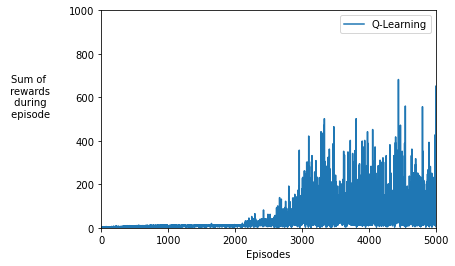

In [34]:
plot_rewards(all_rewards,"Q-Learning")

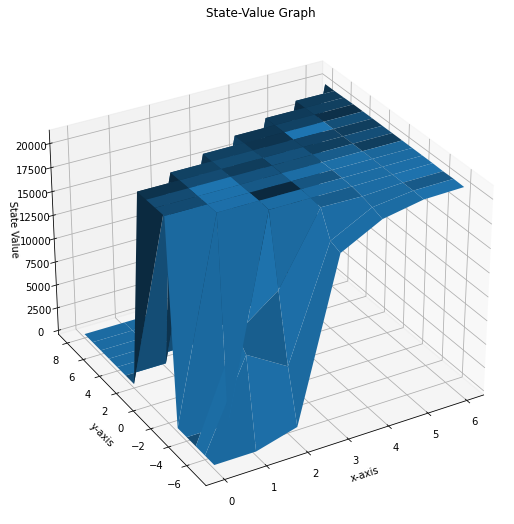

In [35]:
V_q = dict((k,(np.max(v))) for k, v in Q.items())
plot_state_values(V_q)

## Sarsa Agent

In [21]:
def sarsa(env, num_episodes,alpha,discount_factor=1.0,epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    all_rewards=[]
    

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    score_eval = []
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        total_reward = 0.0
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state  
            total_reward+=reward
        all_rewards.append(total_reward)
    
    return Q,all_rewards

In [22]:
Q_sarsa,sarsa_rewards = sarsa(env,50000,alpha=0.5)
S_policy = dict((k,(np.argmax(v))) for k, v in Q_sarsa.items())

Episode 50000/50000.

In [23]:
generate_rewards(sarsa_rewards)

5000 :mean episode reward  34.3098
10000 :mean episode reward  64.0956
15000 :mean episode reward  61.5898
20000 :mean episode reward  64.5252
25000 :mean episode reward  61.797
30000 :mean episode reward  63.5392
35000 :mean episode reward  62.2884
40000 :mean episode reward  63.438
45000 :mean episode reward  64.2544
50000 :mean episode reward  64.4546


In [25]:
print("the total mean reward for sarsa-learning agent is {}".format(np.mean(sarsa_rewards)))

the total mean reward for sarsa-learning agent is 60.4292


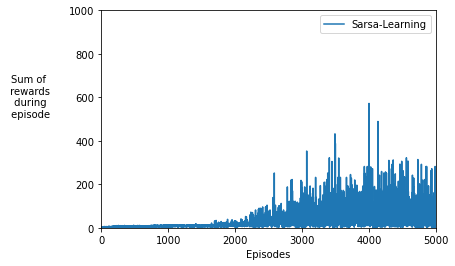

In [26]:
plot_rewards(sarsa_rewards,"Sarsa-Learning")

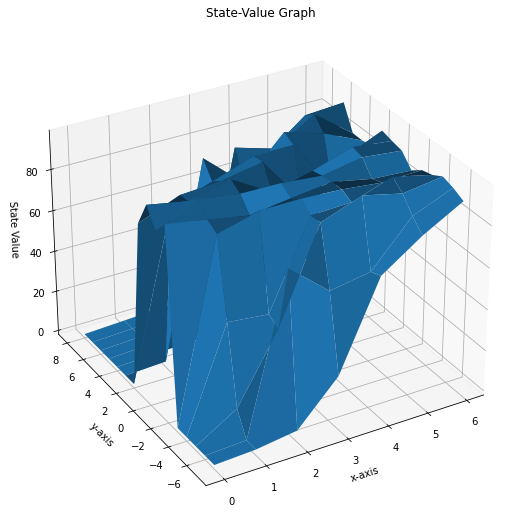

In [27]:
V_sarsa = dict((k,(np.max(v))) for k, v in Q_sarsa.items())
plot_state_values(V_sarsa)

# Evaluation script:
#### Q_policy -policy obtained by agent using Q learning
#### S_policy -policy obtained by agent using sarsa learning

In [29]:
if __name__ == '__main__':

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()

    # iterate
    while True:

        # Select next action
        #action = env.action_space.sample()  # Base line agent random action
        action = S_policy[obs]                 # action corresponding to sarsa agent
        #action = Q_policy[obs]                  # action corresponding to Q agent

        # Appy action and return new observation of the environment
        obs, reward, done, info = env.step(action)
        print(done)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()


False
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (x=12,y=0)
False
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (x=11,y=2)
False
Text Flappy Bird!
Score: 0
-----------------

False
Text Flappy Bird!
Score: 1
----------------------
[    |         |     ]
[    |         |     ]
[    |         |     ]
[    |         |     ]
[    |         |     ]
[              |     ]
[              |     ]
[              |     ]
[      @       |     ]
[    |         |     ]
[    |               ]
[    |               ]
[    |               ]
[    |               ]
[    |         |     ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=8,y=-4)
False
Text Flappy Bird!
Score: 1
----------------------
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[             |      ]
[             |      ]
[      @      |      ]
[             |      ]
[   |         |      ]
[   |                ]
[   |                ]
[   |                ]
[   |                ]
[   |         |      ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=7,y=-5)
False
Text Flappy Bird!
Score: 1
-----------------

False
Text Flappy Bird!
Score: 2
----------------------
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |                  ]
[ |                  ]
[ |                  ]
[ |                  ]
[ |         |        ]
[ |         |        ]
[ |    @    |        ]
[           |        ]
[           |        ]
[           |        ]
[           |        ]
[ |         |        ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=5,y=4)
False
Text Flappy Bird!
Score: 2
----------------------
[|         |         ]
[|         |         ]
[|         |         ]
[|                   ]
[|                   ]
[|                   ]
[|                   ]
[|         |         ]
[|     @   |         ]
[|         |         ]
[          |         ]
[          |         ]
[          |         ]
[          |         ]
[|         |         ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=4,y=3)
False
Text Flappy Bird!
Score: 2
-------------------

False
Text Flappy Bird!
Score: 3
----------------------
[        |         | ]
[        |           ]
[        |           ]
[        |           ]
[        |           ]
[        |         | ]
[        |         | ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[        |         | ]
[        |         | ]
[        |         | ]
[        |         | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (x=2,y=-1)
False
Text Flappy Bird!
Score: 3
----------------------
[       |         |  ]
[       |            ]
[       |            ]
[       |            ]
[       |            ]
[       |         |  ]
[       |         |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=1,y=-2)
False
Text Flappy Bird!
Score: 3
-----------------

False
Text Flappy Bird!
Score: 5
----------------------
[     |         |    ]
[               |    ]
[               |    ]
[      @        |    ]
[               |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |              ]
[     |              ]
[     |              ]
[     |              ]
[     |         |    ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (x=9,y=-9)
False
Text Flappy Bird!
Score: 5
----------------------
[    |         |     ]
[              |     ]
[              |     ]
[              |     ]
[              |     ]
[    |         |     ]
[    | @       |     ]
[    |         |     ]
[    |         |     ]
[    |         |     ]
[    |               ]
[    |               ]
[    |               ]
[    |               ]
[    |         |     ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (x=8,y=-6)
False
Text Flappy Bird!
Score: 5
-----------------

False
Text Flappy Bird!
Score: 6
----------------------
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |   @     |       ]
[  |                 ]
[                    ]
[                    ]
[                    ]
[            |       ]
[  |         |       ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=6,y=-3)
False
Text Flappy Bird!
Score: 6
----------------------
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |    @    |        ]
[ |         |        ]
[ |                  ]
[                    ]
[                    ]
[                    ]
[           |        ]
[ |         |        ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=5,y=-4)
False
Text Flappy Bird!
Score: 6
-----------------

False
Text Flappy Bird!
Score: 7
----------------------
[         |          ]
[                    ]
[                    ]
[                    ]
[                    ]
[         |          ]
[         |          ]
[      @  |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=3,y=4)
False
Text Flappy Bird!
Score: 7
----------------------
[        |         | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[        |         | ]
[      @ |           ]
[        |           ]
[        |           ]
[        |           ]
[        |         | ]
[        |         | ]
[        |         | ]
[        |         | ]
[        |         | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=2,y=3)
False
Text Flappy Bird!
Score: 7
-------------------

False
Text Flappy Bird!
Score: 8
----------------------
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[                |   ]
[                    ]
[      @             ]
[                    ]
[      |             ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=0,y=0)
False
Text Flappy Bird!
Score: 9
----------------------
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[               |    ]
[                    ]
[                    ]
[      @             ]
[     |              ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (x=9,y=0)
False
Text Flappy Bird!
Score: 9
-------------------

False
Text Flappy Bird!
Score: 10
----------------------
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[             |      ]
[                    ]
[      @             ]
[                    ]
[   |                ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=7,y=-1)
False
Text Flappy Bird!
Score: 10
----------------------
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[            |       ]
[      @             ]
[                    ]
[                    ]
[  |                 ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=6,y=-2)
False
Text Flappy Bird!
Score: 10
--------------

False
Text Flappy Bird!
Score: 11
----------------------
[|         |         ]
[|         |         ]
[|         |         ]
[|         |         ]
[|         |         ]
[|         |         ]
[|         |         ]
[|         |         ]
[          |         ]
[          |         ]
[      @             ]
[                    ]
[|                   ]
[|                   ]
[|         |         ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (x=4,y=-2)
False
Text Flappy Bird!
Score: 11
----------------------
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[      @  |          ]
[                    ]
[                    ]
[                    ]
[                    ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=3,y=-3)
False
Text Flappy Bird!
Score: 11
--------------

KeyboardInterrupt: 

In [40]:
agents = [
    "Sarsa_learning","q_learning"
]
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
env_info = {}
num_runs = 100
num_episodes = 100
all_reward_sums = {}

for algorithm in ["Sarsa_learning","q_learning"]:
    for step_size in step_sizes:
        all_reward_sums[(algorithm, step_size)] = []
        return_sum=0
        for run in tqdm(range(num_runs)):
            if algorithm=='q_learning':
                Q_q,q_reward = q_learning(env,num_episodes,step_size)
                return_sum+=np.mean(q_reward)
            if algorithm =='Sarsa_learning':
                Q_sarsa,s_reward = sarsa(env,num_episodes,step_size)
                return_sum+=np.mean(s_reward)
            all_reward_sums[(algorithm, step_size)].append(return_sum/num_episodes)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:08, 11.92it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:07, 12.80it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:07, 13.32it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:07, 12.81it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:06, 12.86it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 13.15it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 12.97it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 12.73it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 12.94it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 12.86it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:06, 12.84it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:05, 12.89it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:05, 13.05it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 13.09it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 13.05it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:05, 13.12it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 12.83it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 12.95it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:02<00:04, 13.27it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:04, 12.91it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:05, 11.40it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 11.89it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 11.80it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:04, 11.76it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:03<00:04, 11.86it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:03, 12.15it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 11.93it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 11.21it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 11.05it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:03, 11.61it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:05<00:03, 11.55it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:05<00:03, 10.93it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 11.50it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 11.89it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 12.43it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 12.57it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:02, 12.76it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:06<00:01, 12.81it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:06<00:01, 12.53it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 12.59it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 12.55it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 12.36it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:01, 12.55it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:07<00:00, 12.78it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:07<00:00, 12.38it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:07<00:00, 12.52it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 12.22it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 12.54it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:07<00:00, 12.41it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:07, 12.99it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:07, 12.06it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:07, 12.22it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:07, 12.17it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:07, 12.40it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:07, 12.41it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:07, 12.19it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 12.30it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 12.23it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 12.17it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:06, 12.14it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:06, 12.18it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:06, 11.68it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:06, 11.66it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 11.84it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:05, 12.04it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 11.94it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:05, 12.03it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:05, 11.51it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:05, 11.76it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 11.84it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 12.23it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 12.31it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:04, 12.40it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:04<00:03, 12.57it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:03, 12.48it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 12.33it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 12.17it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 12.13it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:03, 11.85it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:05<00:03, 11.97it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:05<00:03, 12.00it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 11.93it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 12.34it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 12.35it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 12.86it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:06<00:02, 12.85it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:06<00:01, 13.24it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:06<00:01, 12.76it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 12.60it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 12.55it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 12.51it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:07<00:01, 12.09it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:07<00:01, 11.96it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:07<00:00, 12.22it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:07<00:00, 12.36it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 12.32it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 12.35it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:08<00:00, 12.25it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:08, 12.11it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:08, 11.74it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:07, 11.85it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:07, 12.16it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:07, 12.48it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:07, 12.23it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:07, 11.71it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:07, 11.82it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 12.31it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 12.60it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:06, 12.02it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:06, 12.07it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:06, 12.01it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 12.12it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 12.28it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:05, 12.66it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 12.59it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:05, 12.61it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:04, 12.68it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:04, 12.70it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 12.66it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 12.74it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 12.57it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:04, 12.11it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:04<00:04, 11.73it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:04, 11.98it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 12.02it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 12.08it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 12.11it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:03, 12.01it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:05<00:03, 11.96it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:05<00:02, 12.07it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 12.09it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 12.20it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 12.22it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 12.10it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:06<00:02, 11.94it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:06<00:01, 12.15it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:06<00:01, 12.02it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 12.01it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 11.93it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 11.93it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:07<00:01, 12.62it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:07<00:00, 12.11it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:07<00:00, 12.11it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:07<00:00, 12.73it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 12.68it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 12.84it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:08<00:00, 12.42it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:07, 12.68it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:07, 12.48it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:07, 12.81it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:07, 12.60it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:07, 12.48it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 12.90it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 12.99it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 12.95it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 12.81it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 12.56it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:06, 12.74it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:06, 12.49it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:05, 12.68it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 12.15it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 12.59it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:05, 12.42it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 12.57it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:05, 12.54it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:04, 12.61it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:04, 12.77it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 12.85it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 13.56it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 13.01it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:03, 13.15it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:03<00:03, 13.22it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:03, 13.67it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 13.40it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 12.93it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 12.56it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:03, 12.99it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:04<00:02, 13.15it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:04<00:02, 12.86it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 12.42it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 12.42it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 12.33it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 12.52it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:02, 12.61it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:05<00:01, 12.53it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:06<00:01, 12.35it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 12.00it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 12.22it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 11.80it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:01, 11.83it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:06<00:00, 12.01it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:07<00:00, 11.85it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:07<00:00, 12.26it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 12.23it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 12.24it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:07<00:00, 12.02it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:07, 13.10it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:07, 13.11it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:07, 12.12it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:07, 12.34it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:07, 12.53it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:07, 12.38it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 12.52it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:07, 11.98it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 12.61it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 12.46it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:06, 12.14it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:06, 12.11it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:05, 12.35it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 12.12it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 12.22it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:05, 12.23it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 12.58it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:05, 12.58it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:04, 12.46it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:04, 12.02it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 12.02it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 12.05it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 12.09it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:04, 11.77it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:04<00:04, 11.63it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:03, 12.11it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 12.47it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 12.44it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 12.38it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:03, 12.35it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:05<00:03, 12.47it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:05<00:02, 12.17it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 12.25it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 12.50it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 12.37it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 12.28it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:06<00:02, 11.92it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:06<00:02, 11.82it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:06<00:01, 11.90it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 11.85it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 11.87it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 12.11it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:07<00:01, 12.30it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:07<00:00, 12.09it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:07<00:00, 12.28it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:07<00:00, 12.42it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 12.17it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 12.02it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:08<00:00, 12.31it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:08, 11.91it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:07, 13.27it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:07, 12.85it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:07, 12.87it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:07, 12.85it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 12.77it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 12.78it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 12.76it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 13.00it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 12.91it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:06, 12.65it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:06, 12.55it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:06, 11.92it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 12.11it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 12.08it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:05, 12.02it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 11.77it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:05, 12.18it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:04, 12.50it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:04, 12.08it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 12.38it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 12.26it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 12.32it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:04, 12.33it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:04<00:03, 12.58it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:03, 12.84it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 12.63it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 12.51it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 12.20it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:03, 12.15it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:05<00:03, 11.67it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:05<00:03, 11.62it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 12.02it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 12.28it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 12.69it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 12.52it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:02, 12.74it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:06<00:01, 12.67it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:06<00:01, 12.50it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 12.44it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 12.29it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 12.12it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:01, 12.01it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:07<00:00, 12.10it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:07<00:00, 12.36it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:07<00:00, 11.98it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 11.84it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 12.06it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:07<00:00, 11.98it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:08, 12.03it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:07, 12.57it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:07, 12.02it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:07, 12.39it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:07, 12.20it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:07, 12.50it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 12.30it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:07, 11.92it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 11.73it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 12.01it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:06, 12.00it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:06, 12.22it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:05, 12.37it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 12.35it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 12.14it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:05, 12.61it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 12.84it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 13.10it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:04, 13.26it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:04, 12.84it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 12.78it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 12.34it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 12.58it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:04, 12.53it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:04<00:04, 11.91it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:04, 11.94it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 12.21it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 11.81it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 11.22it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:03, 11.34it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:05<00:03, 11.72it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:05<00:02, 12.13it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 12.08it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 11.44it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 10.84it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 11.02it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:06<00:02, 10.80it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:06<00:02, 11.08it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:06<00:01, 11.20it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 11.01it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 10.70it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:07<00:01, 10.82it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:07<00:01, 10.61it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:07<00:01, 10.66it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:07<00:00, 10.64it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:07<00:00, 10.44it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:08<00:00, 10.34it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:08<00:00, 10.39it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:08<00:00, 10.43it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  1%|▊                                                                                 | 1/100 [00:00<00:12,  8.14it/s]

Episode 100/100.

  3%|██▍                                                                               | 3/100 [00:00<00:09,  9.76it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:10,  8.90it/s]

Episode 100/100.

  5%|████                                                                              | 5/100 [00:00<00:10,  9.10it/s]

Episode 100/100.

  7%|█████▋                                                                            | 7/100 [00:00<00:09,  9.65it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:10,  9.11it/s]

Episode 100/100.

  9%|███████▍                                                                          | 9/100 [00:00<00:09,  9.23it/s]

Episode 100/100.

 11%|████████▉                                                                        | 11/100 [00:01<00:09,  9.82it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:01<00:09,  9.47it/s]

Episode 100/100.

 13%|██████████▌                                                                      | 13/100 [00:01<00:09,  9.04it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:09,  9.14it/s]

Episode 100/100.

 15%|████████████▏                                                                    | 15/100 [00:01<00:09,  9.29it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:09,  9.14it/s]

Episode 100/100.

 17%|█████████████▊                                                                   | 17/100 [00:01<00:09,  9.10it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:09,  9.07it/s]

Episode 100/100.

 19%|███████████████▍                                                                 | 19/100 [00:02<00:09,  8.70it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:02<00:09,  8.55it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:02<00:08,  9.15it/s]

Episode 100/100.

 23%|██████████████████▋                                                              | 23/100 [00:02<00:08,  9.17it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:02<00:08,  9.20it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:07,  9.62it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:06, 10.48it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:03<00:06, 10.18it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:03<00:06, 10.18it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:03<00:06, 10.59it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:03<00:05, 10.69it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:05, 10.94it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:04<00:05, 10.88it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:04<00:05, 10.52it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:04<00:05, 10.37it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:04<00:05, 10.18it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:04<00:04, 10.43it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:05<00:04, 10.40it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:05<00:04, 10.08it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:05<00:04, 10.25it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:05<00:04,  9.77it/s]

Episode 100/100.

 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:05<00:04,  9.52it/s]

Episode 100/100.

 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:06<00:04,  9.73it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:06<00:04,  9.76it/s]

Episode 100/100.

 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:06<00:03,  9.80it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:06<00:03,  9.72it/s]

Episode 100/100.

 63%|███████████████████████████████████████████████████                              | 63/100 [00:06<00:03,  9.72it/s]

Episode 100/100.

 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:06<00:03, 10.49it/s]

Episode 100/100.

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:06<00:03, 10.20it/s]

Episode 100/100.

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:07<00:03, 10.01it/s]

Episode 100/100.

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:07<00:02, 10.16it/s]

Episode 100/100.

 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:07<00:02, 10.11it/s]

Episode 100/100.

 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:07<00:02, 10.32it/s]

Episode 100/100.

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:07<00:02,  9.95it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:07<00:02,  9.67it/s]

Episode 100/100.

 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:08<00:02,  9.45it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:08<00:02,  9.53it/s]

Episode 100/100.

 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:08<00:02,  9.33it/s]

Episode 100/100.

 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:08<00:01,  9.51it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:08<00:01,  9.17it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:08<00:01,  9.93it/s]

Episode 100/100.

 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:08<00:01,  9.92it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:08<00:01,  9.74it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:09<00:00, 10.40it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:09<00:00, 10.98it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:09<00:00, 10.58it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:09<00:00, 10.58it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:09<00:00, 11.15it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  1%|▊                                                                                 | 1/100 [00:00<00:10,  9.52it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:10,  9.32it/s]

Episode 100/100.

  3%|██▍                                                                               | 3/100 [00:00<00:10,  9.61it/s]

Episode 100/100.

  5%|████                                                                              | 5/100 [00:00<00:08, 10.94it/s]

Episode 100/100.

  7%|█████▋                                                                            | 7/100 [00:00<00:08, 10.85it/s]

Episode 100/100.

  9%|███████▍                                                                          | 9/100 [00:00<00:08, 10.98it/s]

Episode 100/100.

 11%|████████▉                                                                        | 11/100 [00:01<00:07, 11.39it/s]

Episode 100/100.

 13%|██████████▌                                                                      | 13/100 [00:01<00:07, 11.46it/s]

Episode 100/100.

 15%|████████████▏                                                                    | 15/100 [00:01<00:07, 11.49it/s]

Episode 100/100.

 17%|█████████████▊                                                                   | 17/100 [00:01<00:07, 11.41it/s]

Episode 100/100.

 19%|███████████████▍                                                                 | 19/100 [00:01<00:07, 11.29it/s]

Episode 100/100.

 21%|█████████████████                                                                | 21/100 [00:01<00:07, 10.85it/s]

Episode 100/100.

 23%|██████████████████▋                                                              | 23/100 [00:02<00:06, 11.14it/s]

Episode 100/100.

 25%|████████████████████▎                                                            | 25/100 [00:02<00:06, 11.65it/s]

Episode 100/100.

 27%|█████████████████████▊                                                           | 27/100 [00:02<00:06, 11.61it/s]

Episode 100/100.

 29%|███████████████████████▍                                                         | 29/100 [00:02<00:06, 10.81it/s]

Episode 100/100.

 31%|█████████████████████████                                                        | 31/100 [00:02<00:06, 10.82it/s]

Episode 100/100.

 33%|██████████████████████████▋                                                      | 33/100 [00:02<00:06, 11.09it/s]

Episode 100/100.

 35%|████████████████████████████▎                                                    | 35/100 [00:03<00:05, 11.21it/s]

Episode 100/100.

 37%|█████████████████████████████▉                                                   | 37/100 [00:03<00:05, 11.39it/s]

Episode 100/100.

 39%|███████████████████████████████▌                                                 | 39/100 [00:03<00:05, 11.61it/s]

Episode 100/100.

 41%|█████████████████████████████████▏                                               | 41/100 [00:03<00:05, 11.67it/s]

Episode 100/100.

 43%|██████████████████████████████████▊                                              | 43/100 [00:03<00:04, 11.95it/s]

Episode 100/100.

 45%|████████████████████████████████████▍                                            | 45/100 [00:03<00:04, 12.27it/s]

Episode 100/100.

 47%|██████████████████████████████████████                                           | 47/100 [00:04<00:04, 12.32it/s]

Episode 100/100.

 49%|███████████████████████████████████████▋                                         | 49/100 [00:04<00:04, 12.13it/s]

Episode 100/100.

 51%|█████████████████████████████████████████▎                                       | 51/100 [00:04<00:03, 12.28it/s]

Episode 100/100.

 53%|██████████████████████████████████████████▉                                      | 53/100 [00:04<00:03, 12.06it/s]

Episode 100/100.

 55%|████████████████████████████████████████████▌                                    | 55/100 [00:04<00:03, 12.12it/s]

Episode 100/100.

 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:04<00:03, 12.35it/s]

Episode 100/100.

 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:05<00:03, 12.48it/s]

Episode 100/100.

 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:05<00:03, 12.20it/s]

Episode 100/100.

 63%|███████████████████████████████████████████████████                              | 63/100 [00:05<00:03, 11.79it/s]

Episode 100/100.

 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:05<00:02, 11.95it/s]

Episode 100/100.

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:05<00:02, 12.15it/s]

Episode 100/100.

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:05<00:02, 11.85it/s]

Episode 100/100.

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:06<00:02, 12.17it/s]

Episode 100/100.

 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:06<00:02, 11.88it/s]

Episode 100/100.

 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:06<00:02, 11.95it/s]

Episode 100/100.

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:06<00:01, 12.06it/s]

Episode 100/100.

 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:06<00:01, 12.31it/s]

Episode 100/100.

 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:06<00:01, 12.11it/s]

Episode 100/100.

 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:07<00:01, 11.98it/s]

Episode 100/100.

 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:07<00:01, 12.02it/s]

Episode 100/100.

 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:07<00:01, 12.23it/s]

Episode 100/100.

 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:07<00:00, 12.31it/s]

Episode 100/100.

 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:07<00:00, 12.58it/s]

Episode 100/100.

 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:07<00:00, 12.35it/s]

Episode 100/100.

 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:08<00:00, 12.18it/s]

Episode 100/100.

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:08<00:00, 12.10it/s]

Episode 100/100.

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:08<00:00, 11.93it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:07, 13.39it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:07, 12.55it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:07, 12.59it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:07, 12.35it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:07, 12.40it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:07, 12.40it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 12.32it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 12.28it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 11.84it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 11.50it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:06, 11.52it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:06, 11.90it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:06, 11.64it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 12.05it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 11.84it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:05, 11.55it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 11.86it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:03<00:05, 11.75it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:05, 11.76it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:05, 11.80it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 11.98it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 12.03it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 11.65it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:04<00:04, 12.07it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:04<00:04, 11.92it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:03, 12.05it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 12.47it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 12.50it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 12.34it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:03, 12.57it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:05<00:03, 12.41it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:05<00:02, 12.28it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 12.44it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 12.25it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 12.48it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 11.94it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:06<00:02, 12.18it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:06<00:01, 12.30it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:06<00:01, 12.04it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 11.68it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 11.45it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 11.60it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:07<00:01, 11.74it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:07<00:01, 11.88it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:07<00:00, 11.67it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:07<00:00, 11.52it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 11.67it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 12.12it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:08<00:00, 12.40it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:07, 12.99it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:06, 14.33it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:06, 13.69it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:06, 13.75it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:06, 13.96it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 14.18it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 14.06it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 13.78it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 13.66it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:05, 13.90it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:05, 14.04it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:05, 14.50it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:01<00:05, 14.54it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:01<00:05, 14.21it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:04, 14.58it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:04, 14.25it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:04, 14.13it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 14.51it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:02<00:04, 14.63it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:02<00:04, 14.77it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:02<00:03, 14.59it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 13.98it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:03, 14.27it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:03, 14.79it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:03<00:03, 14.93it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:03<00:03, 14.97it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:03<00:03, 15.02it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:03<00:02, 15.34it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:02, 14.87it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:02, 14.20it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:04<00:02, 14.48it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:04<00:02, 14.01it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:04<00:02, 13.77it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:04<00:02, 14.05it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:04<00:02, 14.10it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:01, 14.17it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:01, 13.91it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:05<00:01, 14.27it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:05<00:01, 14.00it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:05<00:01, 14.13it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:05<00:01, 14.09it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:05<00:01, 13.97it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:00, 14.34it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:06<00:00, 13.52it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:06<00:00, 13.85it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:06<00:00, 14.05it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:06<00:00, 14.03it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:06<00:00, 14.36it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:06<00:00, 13.67it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:06, 15.37it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:06, 14.93it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:06, 15.05it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:06, 14.65it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:06, 14.39it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 14.08it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:00<00:06, 14.15it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:05, 14.14it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:05, 14.26it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:05, 13.48it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:05, 13.69it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:05, 13.62it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:01<00:05, 13.25it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 13.60it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 13.66it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:04, 13.83it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:04, 14.22it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 13.96it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:02<00:04, 13.80it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:02<00:04, 13.52it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 13.90it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:03, 14.03it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:03, 14.03it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:03, 13.73it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:03<00:03, 14.14it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:03<00:03, 14.30it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:03<00:03, 14.13it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 13.94it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:02, 14.07it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:02, 14.19it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:04<00:02, 14.26it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:04<00:02, 14.39it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:04<00:02, 13.94it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:04<00:02, 14.01it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:04<00:02, 13.94it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 13.52it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:01, 13.47it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:05<00:01, 13.55it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:05<00:01, 13.82it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:05<00:01, 13.76it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:05<00:01, 13.56it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 13.63it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:01, 13.57it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:06<00:00, 14.22it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:06<00:00, 14.06it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:06<00:00, 13.87it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:06<00:00, 13.64it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:06<00:00, 13.46it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:07<00:00, 14.06it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:07, 12.73it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:07, 12.74it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:07, 13.16it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:06, 13.57it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:06, 13.65it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 14.28it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 14.17it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 13.97it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:05, 13.98it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:05, 14.11it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:05, 13.71it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:05, 13.45it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:01<00:05, 13.29it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 13.56it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 13.77it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:04, 14.19it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:04, 14.29it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 13.82it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:02<00:04, 14.29it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:02<00:04, 13.60it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 13.96it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 13.44it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:03, 13.97it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:03, 14.19it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:03<00:03, 14.00it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:03<00:03, 13.40it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:03<00:03, 13.39it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 13.40it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 13.25it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:03, 13.20it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:04<00:02, 13.81it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:04<00:02, 13.93it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:04<00:02, 14.09it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:04<00:02, 13.63it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 13.59it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 12.89it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:02, 12.93it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:05<00:01, 12.75it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:05<00:01, 12.75it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:05<00:01, 13.13it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 13.43it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 13.30it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:01, 13.70it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:06<00:00, 13.50it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:06<00:00, 13.55it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:06<00:00, 13.93it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:06<00:00, 13.85it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 14.05it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:07<00:00, 13.89it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:06, 14.23it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:07, 13.69it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:06, 14.03it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:06, 14.32it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:06, 13.97it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 13.57it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 13.73it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 13.74it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:05, 14.22it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:05, 13.91it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:05, 13.67it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:05, 13.73it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:01<00:05, 14.02it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 14.12it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 13.58it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:04, 13.81it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:04, 13.90it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 13.62it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:02<00:04, 13.38it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:02<00:04, 12.39it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 12.93it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 12.46it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 12.86it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:04, 12.99it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:03<00:03, 13.13it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:03<00:03, 13.28it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:03<00:03, 13.73it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 13.62it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 13.63it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:02, 13.70it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:04<00:02, 13.18it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:04<00:02, 12.91it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:04<00:02, 13.40it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 13.43it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 13.07it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 13.21it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:02, 12.93it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:05<00:01, 13.25it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:05<00:01, 13.16it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:05<00:01, 13.20it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 13.23it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 13.24it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:01, 12.99it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:06<00:00, 13.24it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:06<00:00, 13.90it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:06<00:00, 13.61it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:06<00:00, 13.81it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 13.41it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:07<00:00, 12.99it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:06, 14.09it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:06, 13.78it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:08, 11.72it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:07, 11.71it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:07, 11.78it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:07, 12.08it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:07, 12.11it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 12.28it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 12.95it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 13.09it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:05, 13.33it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:05, 13.49it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:05, 13.36it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 13.28it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 13.24it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:04, 13.67it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 13.07it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 12.83it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:02<00:04, 13.60it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:04, 13.29it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 13.22it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 13.26it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 13.02it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:03, 13.34it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:03<00:03, 13.28it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:03, 13.06it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 13.31it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 13.44it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 13.42it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:02, 13.47it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:04<00:02, 12.78it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:04<00:02, 12.84it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 12.75it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 12.77it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 13.34it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 13.14it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:02, 12.92it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:05<00:01, 12.89it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:05<00:01, 13.18it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 13.29it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 13.40it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 13.47it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:01, 12.87it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:06<00:00, 13.48it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:06<00:00, 13.30it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:07<00:00, 13.48it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 13.39it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 13.33it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:07<00:00, 13.49it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:07, 13.50it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:07, 12.36it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:07, 12.55it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:07, 12.87it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:06, 13.16it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 12.69it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 12.52it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 12.97it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 12.67it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 12.61it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:06, 12.56it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:06, 12.49it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:06, 12.27it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 12.13it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 12.28it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:05, 12.74it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 12.50it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:05, 12.57it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:05, 12.39it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:04, 12.58it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 12.98it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 12.28it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 11.69it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:04, 11.89it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:04<00:04, 12.42it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:03, 12.65it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 12.83it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 13.15it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 13.58it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:02, 13.82it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:04<00:02, 13.56it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:05<00:02, 13.49it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 13.74it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 14.10it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 14.50it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:01, 15.51it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:01, 14.40it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:05<00:01, 13.79it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:06<00:01, 13.75it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 13.32it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 13.04it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 13.09it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:01, 13.45it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:06<00:00, 13.84it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:06<00:00, 13.73it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:07<00:00, 13.33it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 13.42it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 13.20it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:07<00:00, 13.02it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:06, 15.20it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:06, 14.63it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:06, 14.15it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:06, 13.74it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:06, 13.31it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 13.56it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 13.75it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 13.50it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 12.63it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 12.83it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:05, 13.17it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:05, 13.32it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:01<00:05, 13.42it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 13.38it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 13.31it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:05, 12.69it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 13.12it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 13.05it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:02<00:04, 13.16it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:02<00:04, 13.46it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 13.73it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 13.65it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 13.31it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:03, 13.17it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:03<00:03, 13.34it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:03<00:03, 13.45it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 13.67it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 13.49it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 13.17it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:03, 12.90it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:04<00:02, 13.32it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:04<00:02, 13.29it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:04<00:02, 12.89it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 13.05it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 12.77it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 12.92it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:01, 13.31it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:05<00:01, 13.81it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:05<00:01, 13.91it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 13.38it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 13.50it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 13.32it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:01, 12.98it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:06<00:00, 13.14it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:06<00:00, 13.35it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:06<00:00, 13.47it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 13.66it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 13.63it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:07<00:00, 12.88it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:07, 13.65it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:06, 13.87it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:06, 13.59it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:06, 13.44it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:06, 13.77it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 13.76it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:06, 13.36it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:06, 13.41it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 12.84it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 12.67it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:06, 12.83it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:06, 12.37it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:01<00:05, 12.90it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 13.43it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 13.20it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:04, 13.74it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:04, 13.29it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 13.25it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:02<00:04, 13.31it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:04, 13.12it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 12.91it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 13.29it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:03, 13.91it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:03, 14.04it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:03<00:03, 13.66it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:03<00:03, 13.28it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 13.02it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 13.43it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 13.59it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:02, 13.55it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:04<00:02, 13.81it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:04<00:02, 13.09it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:04<00:02, 13.33it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 13.01it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 12.30it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 12.02it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:02, 12.56it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:05<00:01, 13.02it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:05<00:01, 13.24it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 13.54it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 13.40it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 13.45it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:01, 13.98it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:06<00:00, 13.71it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:06<00:00, 13.30it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:06<00:00, 13.32it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 13.42it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 14.10it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:07<00:00, 13.89it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  2%|█▋                                                                                | 2/100 [00:00<00:07, 13.19it/s]

Episode 100/100.

  4%|███▎                                                                              | 4/100 [00:00<00:07, 13.19it/s]

Episode 100/100.

  6%|████▉                                                                             | 6/100 [00:00<00:07, 12.29it/s]

Episode 100/100.

  8%|██████▌                                                                           | 8/100 [00:00<00:07, 12.60it/s]

Episode 100/100.

 10%|████████                                                                         | 10/100 [00:00<00:07, 12.27it/s]

Episode 100/100.

 12%|█████████▋                                                                       | 12/100 [00:00<00:06, 12.65it/s]

Episode 100/100.

 14%|███████████▎                                                                     | 14/100 [00:01<00:07, 12.18it/s]

Episode 100/100.

 16%|████████████▉                                                                    | 16/100 [00:01<00:07, 11.21it/s]

Episode 100/100.

 18%|██████████████▌                                                                  | 18/100 [00:01<00:06, 11.76it/s]

Episode 100/100.

 20%|████████████████▏                                                                | 20/100 [00:01<00:06, 12.13it/s]

Episode 100/100.

 22%|█████████████████▊                                                               | 22/100 [00:01<00:06, 12.45it/s]

Episode 100/100.

 24%|███████████████████▍                                                             | 24/100 [00:01<00:06, 12.58it/s]

Episode 100/100.

 26%|█████████████████████                                                            | 26/100 [00:02<00:05, 13.00it/s]

Episode 100/100.

 28%|██████████████████████▋                                                          | 28/100 [00:02<00:05, 12.75it/s]

Episode 100/100.

 30%|████████████████████████▎                                                        | 30/100 [00:02<00:05, 13.01it/s]

Episode 100/100.

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:05, 12.70it/s]

Episode 100/100.

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:05, 12.68it/s]

Episode 100/100.

 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:05, 11.88it/s]

Episode 100/100.

 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:05, 11.63it/s]

Episode 100/100.

 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:05, 11.78it/s]

Episode 100/100.

 42%|██████████████████████████████████                                               | 42/100 [00:03<00:04, 12.27it/s]

Episode 100/100.

 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:04, 12.37it/s]

Episode 100/100.

 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:04, 12.80it/s]

Episode 100/100.

 48%|██████████████████████████████████████▉                                          | 48/100 [00:03<00:04, 12.73it/s]

Episode 100/100.

 50%|████████████████████████████████████████▌                                        | 50/100 [00:04<00:03, 12.63it/s]

Episode 100/100.

 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:03, 12.95it/s]

Episode 100/100.

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:04<00:03, 12.58it/s]

Episode 100/100.

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:03, 12.02it/s]

Episode 100/100.

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:04<00:03, 12.04it/s]

Episode 100/100.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:04<00:03, 12.31it/s]

Episode 100/100.

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:05<00:03, 12.29it/s]

Episode 100/100.

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:05<00:02, 12.49it/s]

Episode 100/100.

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 12.49it/s]

Episode 100/100.

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:05<00:02, 12.70it/s]

Episode 100/100.

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:05<00:02, 12.74it/s]

Episode 100/100.

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:05<00:02, 12.41it/s]

Episode 100/100.

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:02, 12.87it/s]

Episode 100/100.

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:06<00:01, 12.92it/s]

Episode 100/100.

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:06<00:01, 13.20it/s]

Episode 100/100.

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:06<00:01, 13.06it/s]

Episode 100/100.

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:06<00:01, 13.66it/s]

Episode 100/100.

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:06<00:01, 13.70it/s]

Episode 100/100.

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:01, 13.06it/s]

Episode 100/100.

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:07<00:00, 12.97it/s]

Episode 100/100.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:07<00:00, 12.85it/s]

Episode 100/100.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:07<00:00, 12.81it/s]

Episode 100/100.

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:07<00:00, 12.78it/s]

Episode 100/100.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 12.64it/s]

Episode 100/100.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:07<00:00, 12.63it/s]

Episode 100/100.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Episode 100/100.

  1%|▊                                                                                 | 1/100 [00:00<00:10,  9.51it/s]

Episode 100/100.

  3%|██▍                                                                               | 3/100 [00:00<00:08, 11.96it/s]

Episode 100/100.

  5%|████                                                                              | 5/100 [00:00<00:07, 12.54it/s]

Episode 100/100.

  7%|█████▋                                                                            | 7/100 [00:00<00:07, 12.69it/s]

Episode 100/100.

  9%|███████▍                                                                          | 9/100 [00:00<00:07, 12.88it/s]

Episode 100/100.

 11%|████████▉                                                                        | 11/100 [00:00<00:07, 12.46it/s]

Episode 100/100.

 13%|██████████▌                                                                      | 13/100 [00:01<00:06, 12.53it/s]

Episode 100/100.

 15%|████████████▏                                                                    | 15/100 [00:01<00:06, 12.51it/s]

Episode 100/100.

 17%|█████████████▊                                                                   | 17/100 [00:01<00:06, 12.52it/s]

Episode 100/100.

 19%|███████████████▍                                                                 | 19/100 [00:01<00:06, 12.79it/s]

Episode 100/100.

 21%|█████████████████                                                                | 21/100 [00:01<00:06, 12.79it/s]

Episode 100/100.

 23%|██████████████████▋                                                              | 23/100 [00:01<00:05, 12.98it/s]

Episode 100/100.

 25%|████████████████████▎                                                            | 25/100 [00:01<00:05, 13.10it/s]

Episode 100/100.

 27%|█████████████████████▊                                                           | 27/100 [00:02<00:05, 13.35it/s]

Episode 100/100.

 29%|███████████████████████▍                                                         | 29/100 [00:02<00:05, 13.03it/s]

Episode 100/100.

 31%|█████████████████████████                                                        | 31/100 [00:02<00:05, 12.78it/s]

Episode 100/100.

 33%|██████████████████████████▋                                                      | 33/100 [00:02<00:05, 12.54it/s]

Episode 100/100.

 35%|████████████████████████████▎                                                    | 35/100 [00:02<00:05, 12.20it/s]

Episode 100/100.

 37%|█████████████████████████████▉                                                   | 37/100 [00:02<00:05, 11.95it/s]

Episode 100/100.

 39%|███████████████████████████████▌                                                 | 39/100 [00:03<00:04, 12.21it/s]

Episode 100/100.

 41%|█████████████████████████████████▏                                               | 41/100 [00:03<00:04, 12.62it/s]

Episode 100/100.

 43%|██████████████████████████████████▊                                              | 43/100 [00:03<00:04, 12.54it/s]

Episode 100/100.

 45%|████████████████████████████████████▍                                            | 45/100 [00:03<00:04, 13.15it/s]

Episode 100/100.

 47%|██████████████████████████████████████                                           | 47/100 [00:03<00:04, 13.03it/s]

Episode 100/100.

 49%|███████████████████████████████████████▋                                         | 49/100 [00:03<00:03, 12.84it/s]

Episode 100/100.

 51%|█████████████████████████████████████████▎                                       | 51/100 [00:04<00:03, 12.74it/s]

Episode 100/100.

 53%|██████████████████████████████████████████▉                                      | 53/100 [00:04<00:03, 12.72it/s]

Episode 100/100.

 55%|████████████████████████████████████████████▌                                    | 55/100 [00:04<00:03, 12.46it/s]

Episode 100/100.

 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:04<00:03, 12.56it/s]

Episode 100/100.

 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:04<00:03, 12.51it/s]

Episode 100/100.

 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:04<00:03, 12.51it/s]

Episode 100/100.

 63%|███████████████████████████████████████████████████                              | 63/100 [00:05<00:03, 12.30it/s]

Episode 100/100.

 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:05<00:02, 12.11it/s]

Episode 100/100.

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:05<00:02, 12.10it/s]

Episode 100/100.

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:05<00:02, 12.39it/s]

Episode 100/100.

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:05<00:02, 13.20it/s]

Episode 100/100.

 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:05<00:02, 13.16it/s]

Episode 100/100.

 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:05<00:01, 13.20it/s]

Episode 100/100.

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:06<00:01, 13.13it/s]

Episode 100/100.

 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:06<00:01, 12.93it/s]

Episode 100/100.

 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:06<00:01, 12.65it/s]

Episode 100/100.

 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:06<00:01, 12.54it/s]

Episode 100/100.

 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:06<00:01, 12.68it/s]

Episode 100/100.

 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:06<00:00, 13.31it/s]

Episode 100/100.

 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:07<00:00, 13.14it/s]

Episode 100/100.

 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:07<00:00, 13.07it/s]

Episode 100/100.

 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:07<00:00, 12.70it/s]

Episode 100/100.

 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:07<00:00, 12.40it/s]

Episode 100/100.

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:07<00:00, 12.56it/s]

Episode 100/100.

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:07<00:00, 12.70it/s]

Episode 100/100.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.68it/s]


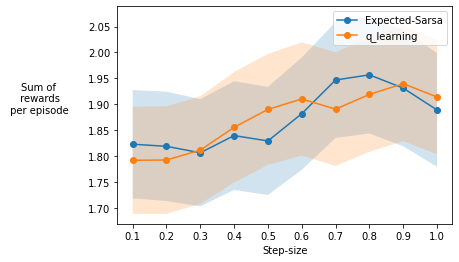

In [39]:
for algorithm in ["Sarsa_learning","q_learning"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()